`Load Environment`

In [0]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
# !pip install tqdm
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
start = dt.datetime.now()

`Load and Simplify data`

In [4]:
!pip install kaggle

In [5]:
!touch ~/.kaggle/kaggle.json
!echo "{\"username\":\"zcunique\",\"key\":\"4bfa103616c5c7a66ea886d326eb90cb\"}" > ~/.kaggle/kaggle.json
!kaggle competitions download -c quickdraw-doodle-recognition

 95% 5.00M/5.24M [00:00<00:00, 22.5MB/s]
100% 5.24M/5.24M [00:00<00:00, 23.4MB/s]
 98% 577M/589M [00:12<00:00, 41.1MB/s]
100% 589M/589M [00:12<00:00, 48.9MB/s]
 98% 58.0M/59.0M [00:00<00:00, 57.9MB/s]
100% 59.0M/59.0M [00:00<00:00, 92.0MB/s]
100% 65.9G/65.9G [29:11<00:00, 64.5MB/s]
100% 65.9G/65.9G [29:11<00:00, 40.4MB/s]
100% 7.37G/7.37G [02:10<00:00, 96.1MB/s]
100% 7.37G/7.37G [02:10<00:00, 60.5MB/s]


In [0]:
!mkdir ./input/
!mkdir ./input/quickdraw-doodle-recognition
!mkdir ./input/shuffle-csvs

# !unzip -q train_raw.zip -d ./input/quickdraw-doodle-recognition/
!unzip -q train_simplified.zip -d ./input/quickdraw-doodle-recognition/
# !mv test_raw.csv ./input/quickdraw-doodle-recognition/
# !mv sample_submission.csv ./input/quickdraw-doodle-recognition/
# !mv test_simplified.csv ./input/quickdraw-doodle-recognition/

In [0]:
def f2cat(filename):
    return filename.split('.')[0]


class Simplified():
    def __init__(self, input_path = './input'):
        self.input_path = input_path
    
    def list_all_categories(self):
        files = os.listdir(os.path.join(self.input_path, 'quickdraw-doodle-recognition'))
        return sorted([f2cat(f) for f in files],key=str.lower)
    
    def read_training_csv(self, category, nrows=None, usecols=None, drawing_transform=False):
        df = pd.read_csv(os.path.join(self.input_path, 'quickdraw-doodle-recognition', category+'.csv'),
                        nrows=nrows, parse_dates= ['timestamp'], usecols=usecols)
        if drawing_transform:
            df['drawing'] = df['drawing'].apply(ast.literal_eval)
        return df

In [8]:
start = dt.datetime.now()
s = Simplified('./input')
NCSVS = 100
categories = s.list_all_categories()
print(len(categories))

340


In [10]:
for y, cat in tqdm(enumerate(categories)):
    df = s.read_training_csv(cat, nrows=40000)
    df['y'] = y
    df['cv'] = (df.key_id // 10 ** 7) % NCSVS # a random int to decide which shuffle csv it should go into
    for k in range(NCSVS):
        filename = './input/shuffle-csvs/train_k{}.csv'.format(k)
        chunk = df[df.cv == k]
        chunk = chunk.drop(['key_id'], axis=1)
        if y == 0:
            chunk.to_csv(filename, index=False)
        else:
            chunk.to_csv(filename, mode='a', header=False, index=False)
            

for k in tqdm(range(NCSVS)):
    filename = './input/shuffle-csvs/train_k{}.csv'.format(k)
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        df['rnd'] = np.random.rand(len(df))
        df = df.sort_values(by='rnd').drop('rnd', axis=1)
        df.to_csv(filename + '.gz', compression='gzip', index=False)
        os.remove(filename)
print(df.shape)

340it [06:56,  1.18s/it]
100%|██████████| 100/100 [1:07:16<00:00, 40.29s/it]

(135903, 7)


`Train and Test`

In [0]:
DP_DIR = './input/shuffle-csvs/'
INPUT_DIR = './input/quickdraw-doodle-recognition/'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

# def list_all_categories():
#     files = os.listdir(os.path.join(INPUT_DIR, 'shuffle-csvs'))
#     return sorted([f2cat(f) for f in files], key=str.lower)

In [0]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
STEPS = 800
EPOCHS = 30
size = 64
# size = 128
batchsize = 680

In [14]:
model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
__________

In [0]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [16]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 64, 64, 1) (34000, 340)
Validation array memory 0.52 GB


In [0]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

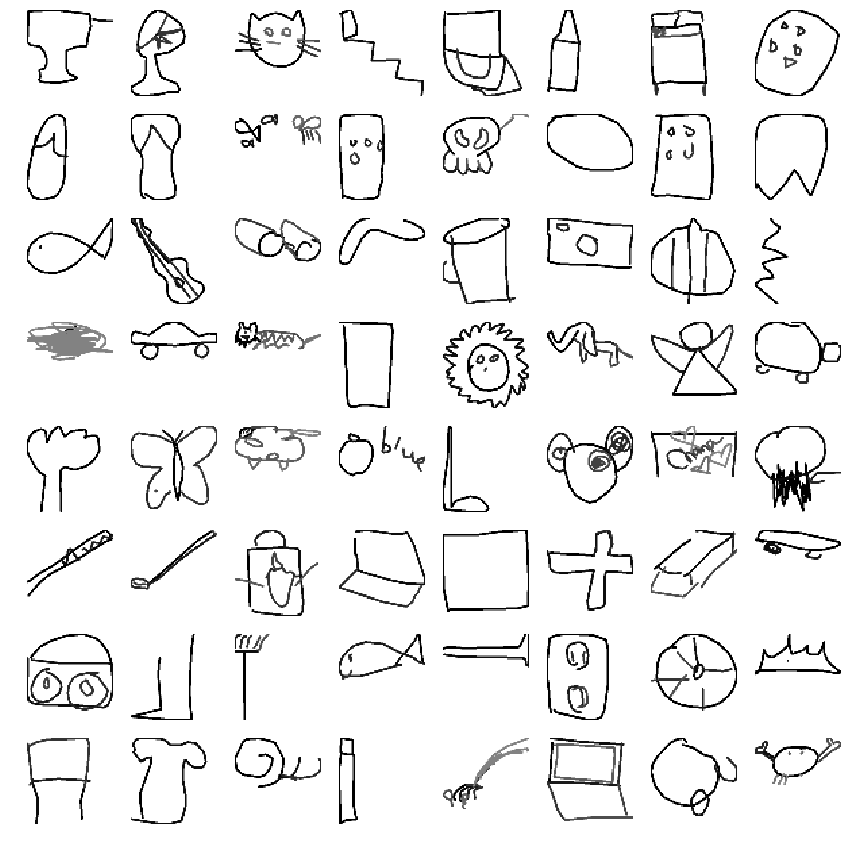

In [18]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [19]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/30
800/800 [==============================] - 409s 512ms/step - loss: 2.8140 - categorical_crossentropy: 2.8140 - categorical_accuracy: 0.3712 - top_3_accuracy: 0.5559 - val_loss: 2.9036 - val_categorical_crossentropy: 2.9036 - val_categorical_accuracy: 0.3831 - val_top_3_accuracy: 0.5922
Epoch 2/30
800/800 [==============================] - 390s 488ms/step - loss: 1.6720 - categorical_crossentropy: 1.6720 - categorical_accuracy: 0.5857 - top_3_accuracy: 0.7851 - val_loss: 2.2147 - val_categorical_crossentropy: 2.2147 - val_categorical_accuracy: 0.4673 - val_top_3_accuracy: 0.6915
Epoch 3/30
800/800 [==============================] - 398s 498ms/step - loss: 1.4479 - categorical_crossentropy: 1.4479 - categorical_accuracy: 0.6363 - top_3_accuracy: 0.8231 - val_loss: 1.6984 - val_categorical_crossentropy: 1.6984 - val_categorical_accuracy: 0.5759 - val_top_3_accuracy: 0.7808
Epoch 4/30
800/800 [==============================] - 393s 492ms/step - loss: 1.3389 - categorical_crossen

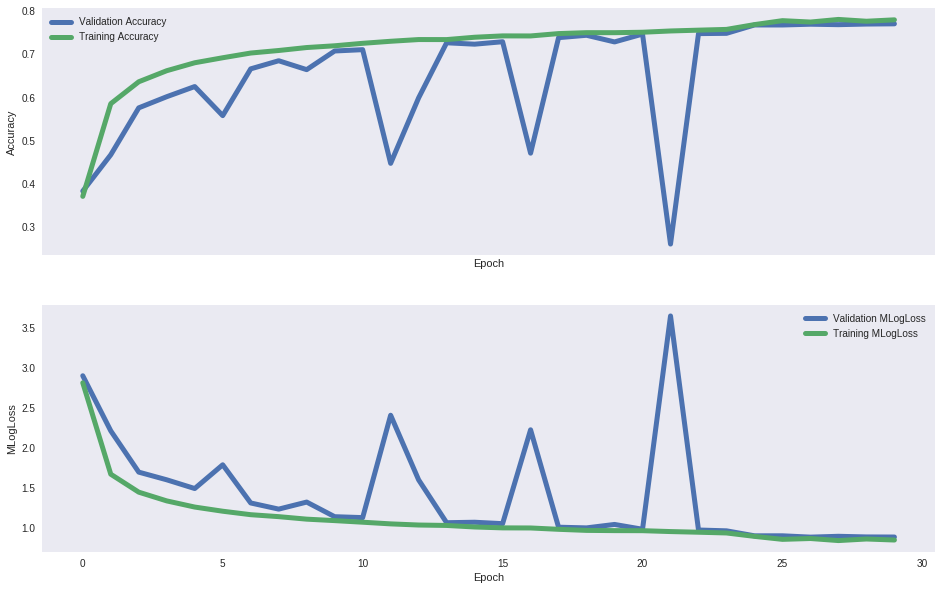

In [20]:
hist_df = pd.DataFrame(hist.history)
hist_df.to_csv('gs_mobile_history.csv', index=False)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [21]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

34000/34000 [==============================] - 9s 271us/step
Map3: 0.831


`Create Submission`

In [22]:
test = pd.read_csv('test_simplified.csv')
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


(112199, 3) (112199, 64, 64, 1)
Test array memory 1.71 GB


In [23]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(categories)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

112199/112199 [==============================] - 27s 239us/step


,a,b,c
0,234,281,285
1,144,36,226
2,305,62,110
3,187,303,127
4,56,113,165


(112199, 3)

,a,b,c
0,radio,stereo,stove
1,hockey_puck,bottlecap,pool
2,The_Great_Wall_of_China,castle,fence
3,mountain,tent,garden_hose
4,campfire,fireplace,leaf


(112199, 3)

In [24]:
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('gs_mn_submission_{}.csv'.format(int(map3 * 10**4)), index=False)
submission.head()
submission.shape

,key_id,word
0,9000003627287624,radio stereo stove
1,9000010688666847,hockey_puck bottlecap pool
2,9000023642890129,The_Great_Wall_of_China castle fence
3,9000038588854897,mountain tent garden_hose
4,9000052667981386,campfire fireplace leaf


(112199, 2)

In [25]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

Latest run 2018-11-10 23:02:10.588017.
Total time 21054s


In [26]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

saved_file = 'gs_mn_submission_{}.csv'.format(int(map3 * 10**4))

# Create & upload a file.
uploaded = drive.CreateFile({'title': saved_file})
uploaded.SetContentFile(saved_file)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1AyrfoNHN-YRhSwrDmHGZHd3qLV9UI7F2
